## Data analysis

In [1]:
from l_p2 import persistence_length
import matplotlib.pyplot as plt
import numpy as np
import scipy
import MDAnalysis as mda
from MDAnalysis.analysis import polymer
import glob
import pandas as pd
from scipy.stats import linregress
import os
from polymer_dictionary import polymer_dictionary

from pl_com import persistence_length1

ref_length = 0.3563594872561357

/home/jbieri/miniforge3/envs/p_l/lib/python3.11/site-packages/foyer/forcefield.py:34: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import iter_entry_points, resource_filename
/home/jbieri/miniforge3/envs/p_l/lib/python3.11/site-packages/pkg_resources/__init__.py:3146: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)



Support for writing out LAMMPS data files will be removed
in mbuild 1.0.
See GMSO (https://github.com/mosdef-hub/gmso/tree/main/gmso/formats/lammpsdata) for
continued support for LAMMPS.



In [21]:
# Getting a sorted list of the 10mer trajectories
key_list = sorted(list(polymer_dictionary.keys())) # Aligning dictionary and path to aid automation
path = os.getcwd() # Non-user specific path
molecule_list = sorted(glob.glob(path+"/gsd_files/10_mers/"+"*_10mer.gsd"))

In [29]:
subfolders = [str(i) for i in range(100, 1600, 100)]
all_mol_list = []
all_mol_list.append(molecule_list)

for subfolder in subfolders:
    folder_path = os.path.join(path, "gsd_files", "10_mers", subfolder)
    molecules = sorted(glob.glob(os.path.join(folder_path, "*.gsd")))
    all_mol_list.append(molecules)


### Calculating persistence lengths:

In [97]:
p_lens = []
for mol_list in all_mol_list:
    i = 0
    for filepath in mol_list:
        h = persistence_length(filepath=filepath,
                           atom_index=polymer_dictionary.get(key_list[i]).get("Sulfur index"),
                           monomer_count=10,
                           start=50)
        l_p = h[0]
        l_b = h[1]
        x_values = h[2]
        C_n = h[3]
        exp_fit = h[4]
        decorr = h[-2]
        i += 1
        p_lens.append(l_p*ref_length*10)

In [ ]:
start = 100
stop = 1600
step = 100

seeds = [12345] + [i for i in range(start, stop, step)]


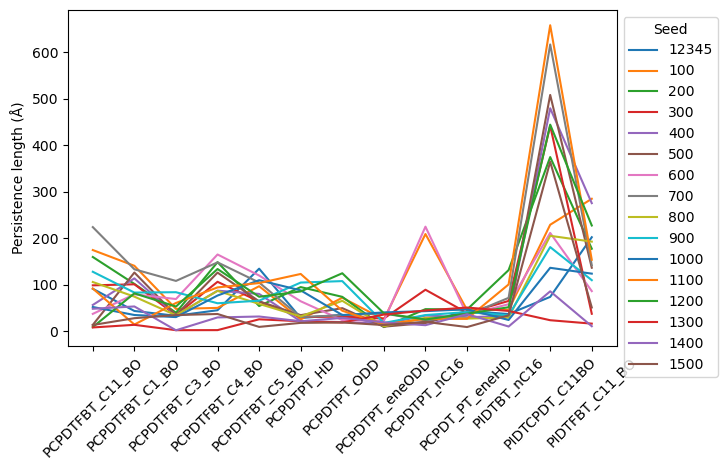

In [32]:
for i in range(len(seeds)):
    plt.plot(key_list,p_lens[i*13:(i+1)*13])
plt.xticks(rotation=45)
plt.tight_layout()
plt.ylabel("Persistence length (Å)")
plt.legend(seeds, title="Seed", loc="upper left", bbox_to_anchor=(1, 1))

In [47]:
positions = np.linspace(1,13,13)
print(positions)

[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13.]


In [99]:
# Makes a list of each molecule
copy = []
for i in range(len(key_list)):
    copy.append(p_lens[i::16])

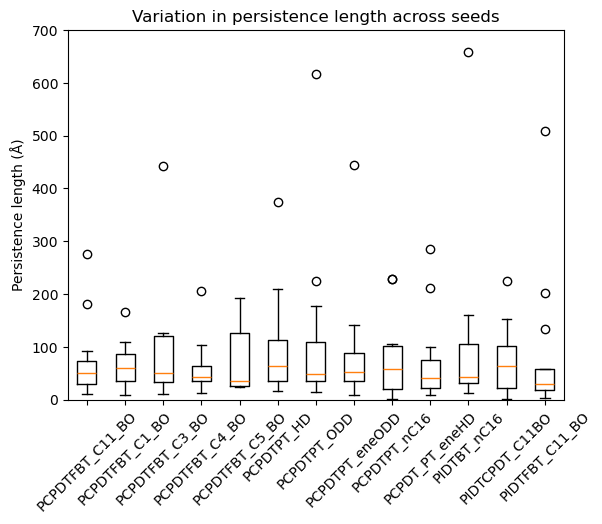

In [96]:
plt.boxplot(copy, tick_labels=key_list)
plt.ylim(0,700)
plt.xticks(rotation=45)
plt.title("Variation in persistence length across seeds")
plt.ylabel("Persistence length (Å)")
plt.show()

In [112]:
from scipy.stats import chisquare, chi2_contingency

In [113]:
independence = []
for i in range(len(key_list)):
    chi2_statistic, p_value, dof, expected_frequencies = chi2_contingency(copy[i])
    independence.append(p_value)

In [126]:
x = list(range(len(independence))) 

Text(0, 0.5, 'P value')

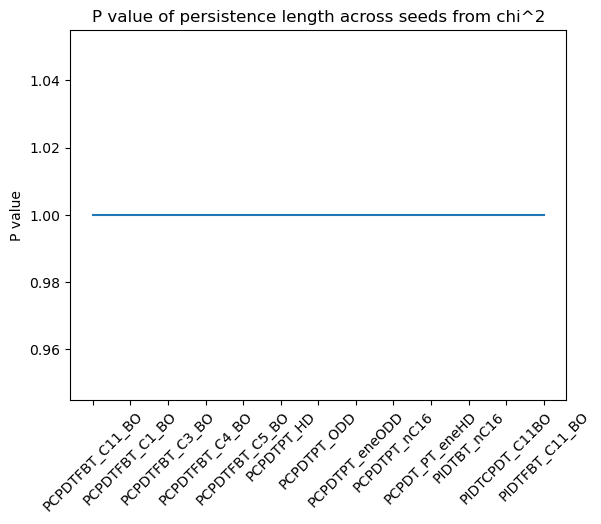

In [127]:
plt.plot(independence)
plt.xticks(ticks=x, labels=key_list, rotation=45)
plt.title("P value of persistence length across seeds from chi^2")
plt.ylabel("P value")

## Comparison against Danielsen et al. paper

In [8]:
measured_pl = [291, 67.0, 78.4, 86.4, 114, 47.3, 54.9, 83.4, 61.0, 76.6, 1310, 236, 254] # Measured persistence length using SANS (in alphabetical order)

In [5]:
differences = np.array(measured_pl) - np.array(p_lens)

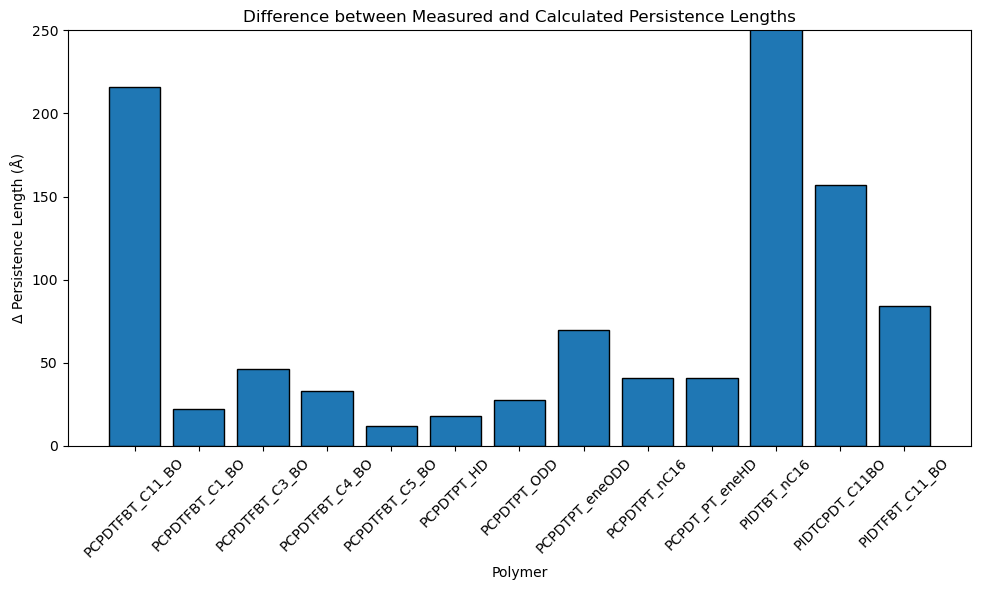

In [6]:
plt.figure(figsize=(10, 6))
plt.bar(key_list[0:len(molecule_list)], differences, edgecolor='black')

plt.xlabel('Polymer')
plt.ylabel('Δ Persistence Length (Å)')
plt.title('Difference between Measured and Calculated Persistence Lengths')
plt.xticks(rotation=45)
plt.tight_layout()
plt.ylim(0,250)
plt.show()

In [14]:
l_p, l_b, x, auto_avg, fit, exp_coeff, acorr, decor, unit_bonds = persistence_length1(
    filepath="test1.gsd", 
    # atom_index=10,        
    monomer_count=10,
    start=499
)

In [15]:
print(l_p*ref_length*10)

8.61844578553949


In [16]:
print(str((l_p*ref_length*10)*10**-10)+" m")

8.618445785539491e-10 m


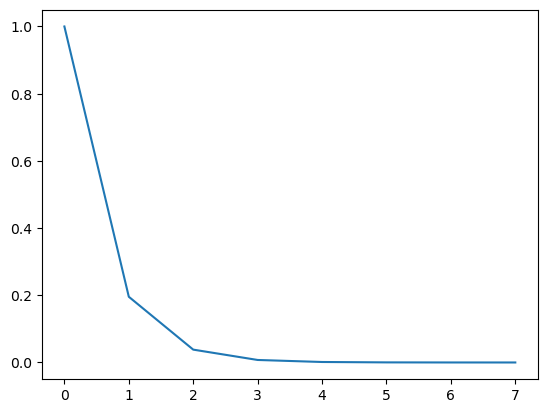

In [20]:
plt.plot(fit)

## Using center of mass of a monomer as input 

In [9]:
p_lens = []
for i in range(len(molecule_list)):
    h = persistence_length(filepath=molecule_list[i],
                       atom_index=polymer_dictionary.get(key_list[i]).get("Sulfur index"),
                       monomer_count=10,
                       start=99)
    l_p = h[0]
    l_b = h[1]
    x_values = h[2]
    C_n = h[3]
    exp_fit = h[4]
    decorr = h[-2]
    p_lens.append(l_p*ref_length*10)

data = {"Polymer": key_list[0:len(molecule_list)], "Persistence length (Å)": p_lens, "Measured length (Å)": measured_pl}
df = pd.DataFrame(data)
print(df)

            Polymer  Persistence length (Å)  Measured length (Å)
0   PCPDTFBT_C11_BO              114.693299                291.0
1    PCPDTFBT_C1_BO               55.078179                 67.0
2    PCPDTFBT_C3_BO                2.096881                 78.4
3    PCPDTFBT_C4_BO               14.251529                 86.4
4    PCPDTFBT_C5_BO              136.313857                114.0
5        PCPDTPT_HD              103.335107                 47.3
6       PCPDTPT_ODD               18.269853                 54.9
7    PCPDTPT_eneODD               10.291984                 83.4
8      PCPDTPT_nC16               90.244484                 61.0
9    PCPDT_PT_eneHD               65.739040                 76.6
10      PIDTBT_nC16               36.159342               1310.0
11   PIDTCPDT_C11BO               26.004300                236.0
12   PIDTFBT_C11_BO              278.262812                254.0


In [11]:
p_lens2 = []
for i in range(len(molecule_list)):
    print(i)
    h = persistence_length1(filepath=all_mol_list[2][i],
                       monomer_count=10,
                       start=40)
    l_p = h[0]
    l_b = h[1]
    x_values = h[2]
    C_n = h[3]
    exp_fit = h[4]
    decorr = h[-2]
    p_lens2.append(l_p*ref_length*10)

data2 = {"Polymer": key_list[0:len(molecule_list)], "Persistence length (Å)": p_lens2, "Measured length (Å)": measured_pl}
df = pd.DataFrame(data2)
print(df)

0
1
2
3
4
5
6
7
8
9
10


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 400.

In [10]:
list1 = np.array(p_lens)
list2 = np.array(p_lens2)

In [11]:
np.set_printoptions(suppress=True)
arrs = np.vstack([list1, list2])
diffs = arrs.max(axis=0) - arrs.min(axis=0)

In [12]:
print(diffs)

[17.76384154  8.619103    0.34837747 18.99192536  9.82366606 11.46285097
  0.02051648  6.99061648  0.28898802 13.71886034  2.11428068  3.06948224
 67.17408079]


## Calculating real temperatures based on epsilon

In [40]:
kb = 1.3806*10**-23
epsilons = [1.046, 1.046, 1.046, 1.046, 1.046, 1.046, 1.046, 1.046, 1.046, 1.046, 1.046, 1.046, 1.046]
temperatures = [252, 503, 1006]
t252 = []
t503 = []
t1006 = []
T = []
for temp in temperatures:
    for i in epsilons:
        T.append((temp*kb)/1.046)

In [38]:
t252 = (T[0:int(len(T)/3)])
t503 = (T[int(len(T)/3):2*int(len(T)/3)])
t1006 = (T[2*int(len(T)/3):])